# Explainability

Import the libraries necessary to analize data

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydotplus
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler



In [80]:
dt = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df = dt.copy(deep = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute involve_killing

In [81]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       187534 non-null  datetime64[ns]
 1   state                      187534 non-null  object        
 2   city_or_county             187534 non-null  object        
 3   latitude                   187534 non-null  float64       
 4   longitude                  187534 non-null  float64       
 5   congressional_district     187534 non-null  int64         
 6   avg_age_participants       187534 non-null  float64       
 7   n_participants_child       187534 non-null  int64         
 8   n_participants_teen        187534 non-null  int64         
 9   n_females                  187534 non-null  float64       
 10  n_killed                   187534 non-null  float64       
 11  n_injured                  187534 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [82]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [83]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

In [84]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187534 entries, 0 to 187533
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   187534 non-null  float64
 1   longitude                  187534 non-null  float64
 2   congressional_district     187534 non-null  int64  
 3   avg_age_participants       187534 non-null  float64
 4   n_participants_child       187534 non-null  int64  
 5   n_participants_teen        187534 non-null  int64  
 6   n_females                  187534 non-null  float64
 7   n_killed                   187534 non-null  float64
 8   n_injured                  187534 non-null  float64
 9   n_arrested                 187534 non-null  float64
 10  n_unharmed                 187534 non-null  float64
 11  n_participants             187534 non-null  float64
 12  povertyPercentage          187534 non-null  float64
 13  candidatevotes             18

In [85]:
#aux
df.drop(columns=['n_killed', 'killed_rate','survival_rate','candidatevotes','longitude','latitude',"females_rate","minor_rate",'incident_gravity','killed_disp_per_district','part_disp_per_district','injured_disp_per_district','injured_rate','arrested_rate', "totalvotes"], axis=1,inplace=True)


In [86]:
label = df.pop('involve_killing')

We partitioned the dataset into training, validation, and test sets using a 70/15/15 split. Additionally, by merging the training and validation sets, we established a development set, comprising 85% of the data, since certain models do not necessitate validation.

In [87]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.15,random_state=10, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_trvl, y_trvl, test_size=0.18,random_state=10, stratify=y_trvl)

Standardization of the data, oversampling and undersampling

In [88]:
scaler = StandardScaler()
X_sc_trvl = scaler.fit_transform(X_trvl)
X_sc_train = scaler.fit_transform(X_train)
X_sc_val = scaler.fit_transform(X_val)
X_sc_test = scaler.fit_transform(X_test)


## Random Forest

import libraries for random forest

In [89]:
from sklearn.ensemble import RandomForestClassifier
rd_fr = RandomForestClassifier(n_estimators=64, 
                             criterion='entropy',
                             max_features="log2",
                             max_depth=5, 
                             min_samples_split=2,
                             min_samples_leaf=4,
                             bootstrap=True) 

We run the classifier and compute the perfomance scores.

In [90]:
rd_fr.fit(X_sc_trvl,y_trvl)
trvl_pred_rf = rd_fr.predict(X_trvl)
test_pred_rf = rd_fr.predict(X_test)


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


Explain random forest with shap

Row 0, label 0

(159403, 15, 2)


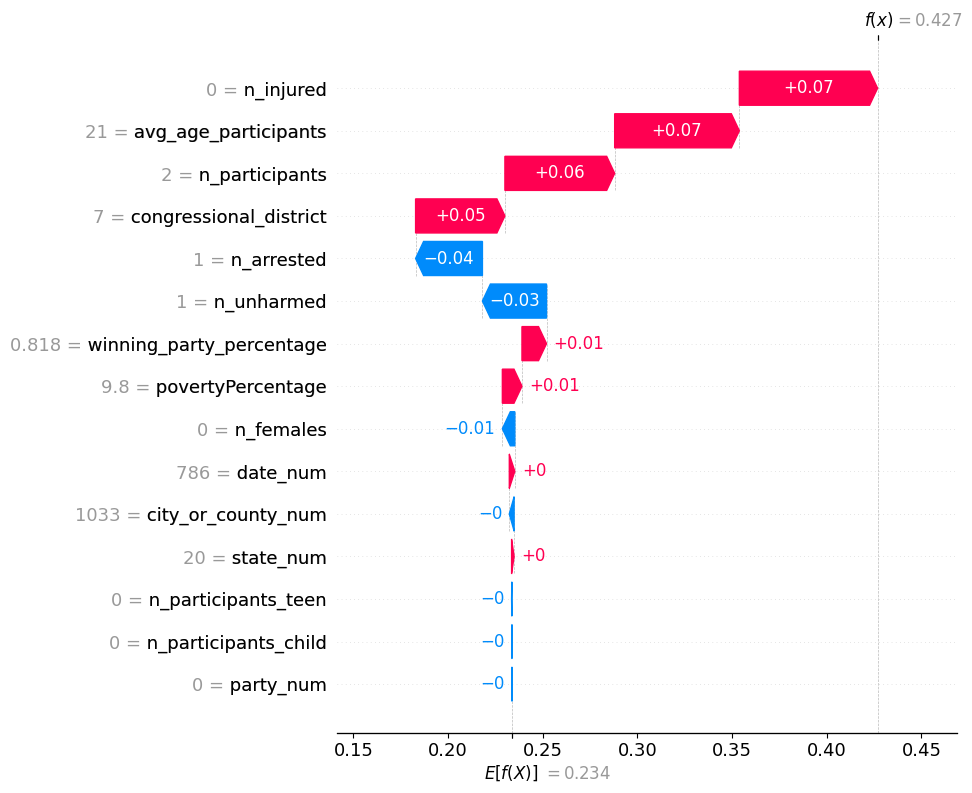

In [91]:
import shap

# explain the model's predictions using SHAP
explainer = shap.Explainer(rd_fr)
shap_values = explainer(X_trvl)

print(shap_values.shape)

# visualize the first prediction's explanation
id_to_explain = 0
output_to_explain = 1
shap.plots.waterfall(shap_values[id_to_explain,:,output_to_explain],max_display=15)

#0.233822
#iskilling = 1



For this instance we can see that 6 features (n_participants_child,n_participants_teen,date_num,state_num,city_or_county_num,party_num) are not helpful to classify this row with index 0.
1) n_females = 0, reduces the chances of having iskilling equal to 1 (1%)
2) povertyPercentage = 9.8%, lower than the mean value (12.0%) but still impactful to classify the row, it increases the probability of having iskilling equal to 1 by 1%
3) winning_party_percentage = 0.818, that further increases the percentage by 2% towards the class 1 for isKilling
4) n_unharmed = 1, decreases the probabilty of having a dead person by 3%. This is understandable since the n_participants drops to 1, knowing that the other one is not dead and the fact that n_killed is linearly calculable from the other features
5) Congressional_district = 7, moves the probability towards 1 by 4%. Since the cities with this congressional district have high rate of homicides (Probable caused by the fact that ???)
6) avg_age_participants = 21, increases the probability by 5%, the number of records that have at least a person killed is 25% (1/4 of records). In this way we can see why it pushes the probability towards the value "1".
7) n_participants = 2, increases by 6% the probability of having a killed person. This because the number of records with 2 participants and having a dead person are 27%.
8) n_injured = 0, since isKilling can be linearly calculated thanks to this value, having it at 0 boosts the classifier towards the iskilling = 1.
Those combined proabibilities gives probability 0.41 that the istance will be classified as 1 and 0.59 to be classified as 0.

In [92]:
dt[dt["n_females"] == 0]

,date,state,city_or_county,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_females,...,females_rate,minor_rate,arrested_rate,survival_rate,winning_party_percentage,killed_rate,injured_rate,killed_disp_per_district,injured_disp_per_district,part_disp_per_district
0,2016-01-14,maryland,Severn,39.121929,-76.708729,3,25.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.631898,0.0,0.0,0.000000,0.0,0.810526
1,2015-03-03,maryland,Anne Arundel (county),39.119550,-76.708250,3,35.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.595491,0.0,0.0,0.000000,0.0,0.723529
2,2015-10-11,maryland,Annapolis,38.970123,-76.503304,4,50.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.701783,0.0,0.0,0.000000,0.0,0.610526
3,2014-11-14,maryland,Pasadena,39.135933,-76.543956,3,21.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.595491,1.0,0.0,5.227273,0.0,0.684524
4,2017-10-27,alaska,Palmer,61.571858,-149.081115,0,31.0,0,0,0.0,...,0.0,0.0,1.0,0.0,0.503209,0.0,0.0,0.000000,0.0,0.791980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187529,2015-04-29,hawaii,Lihue,21.977000,-159.351000,2,30.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.757649,0.0,0.0,0.000000,0.0,0.000000
187530,2015-05-04,hawaii,Puna,19.511800,-154.902000,2,30.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.757649,0.0,0.0,0.000000,0.0,0.000000
187531,2014-09-15,hawaii,Honolulu,21.331600,-157.920000,1,30.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.512377,0.0,0.0,0.000000,0.0,0.000000
187532,2014-11-18,hawaii,Kailua Kona,19.559100,-155.962000,2,30.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.757649,0.0,0.0,0.000000,0.0,0.000000


In [93]:
X_trvl.iloc[0]

congressional_district         7.000000
avg_age_participants          21.000000
n_participants_child           0.000000
n_participants_teen            0.000000
n_females                      0.000000
n_injured                      0.000000
n_arrested                     1.000000
n_unharmed                     1.000000
n_participants                 2.000000
povertyPercentage              9.800000
winning_party_percentage       0.818208
date_num                     786.000000
state_num                     20.000000
city_or_county_num          1033.000000
party_num                      0.000000
Name: 89799, dtype: float64

In [94]:
sorted(dt["state"].unique())[20]


'massachusetts'

In [95]:
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

In [96]:
mean_values = dt.groupby("congressional_district")["n_killed"].mean()
mean_values.sort_values(ascending=False)

congressional_district
45    0.833333
40    0.715847
44    0.686567
37    0.647619
43    0.622047
33    0.568396
34    0.563910
29    0.511883
49    0.506849
32    0.494774
38    0.491803
30    0.470313
42    0.446602
50    0.427083
39    0.402985
41    0.395604
28    0.393120
51    0.380952
36    0.372913
31    0.361409
53    0.360825
47    0.350877
35    0.339400
46    0.325000
14    0.297199
48    0.290323
15    0.288849
20    0.279945
6     0.278887
21    0.277154
5     0.273495
7     0.270530
13    0.269592
22    0.267442
52    0.264957
10    0.263283
12    0.263223
18    0.260849
11    0.257543
9     0.257410
8     0.253488
3     0.253314
4     0.248181
24    0.247844
1     0.244714
2     0.244443
23    0.241166
25    0.240974
16    0.225564
19    0.216954
26    0.201633
0     0.200548
27    0.198191
17    0.142463
Name: n_killed, dtype: float64

In [97]:
print(dt[dt["avg_age_participants"] == 21]["n_killed"].value_counts(True))


n_killed
0.0    0.732417
1.0    0.254813
2.0    0.010806
3.0    0.001572
4.0    0.000393
Name: proportion, dtype: float64


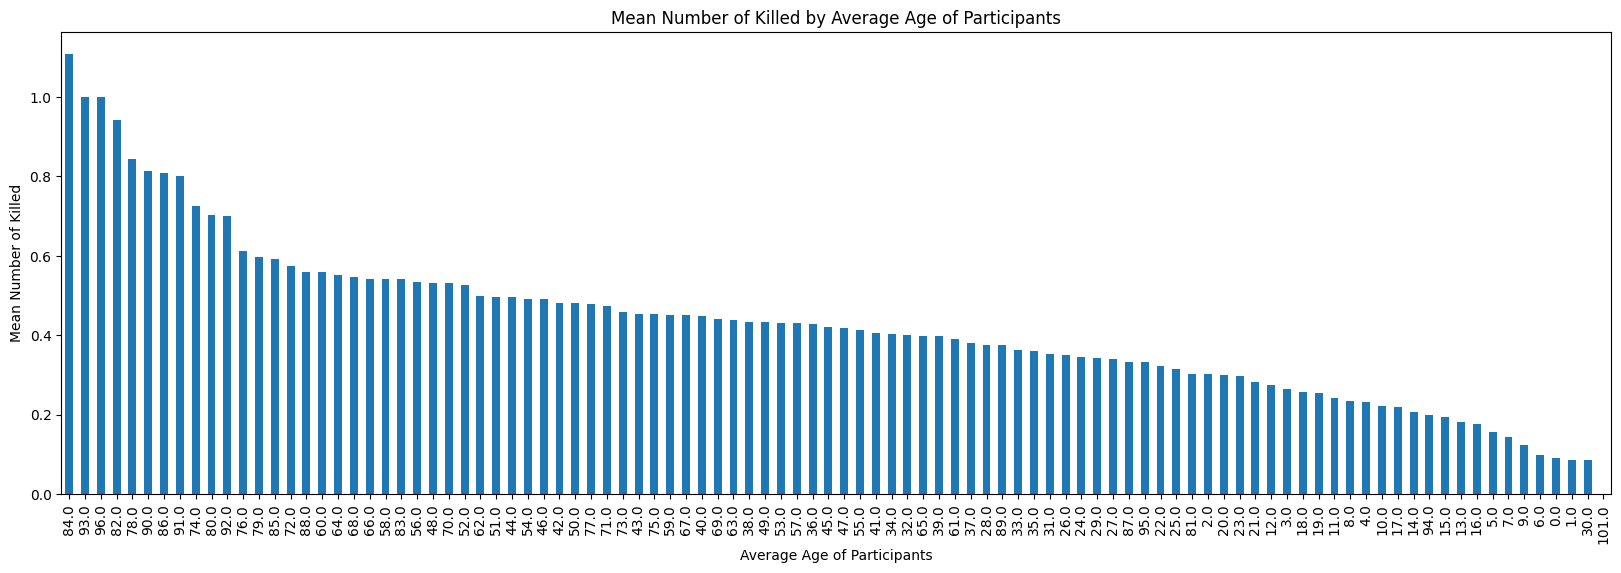

In [98]:

mean_values = dt.groupby("avg_age_participants")["n_killed"].mean()
mean_values_sorted = mean_values.sort_values(ascending=False)
# Plot the bar chart
mean_values_sorted.plot(kind='bar', figsize=(20, 6))
plt.title('Mean Number of Killed by Average Age of Participants')
plt.xlabel('Average Age of Participants')
plt.ylabel('Mean Number of Killed')
plt.show()

In [99]:
print(dt[dt["n_participants"] == 2]["n_killed"].mean())


0.36639077188120295


In [100]:
print(dt[dt["n_participants"] == 2]["n_killed"].value_counts(True))


n_killed
0.0    0.678270
1.0    0.277068
2.0    0.044661
Name: proportion, dtype: float64


Row 31, label 1

1


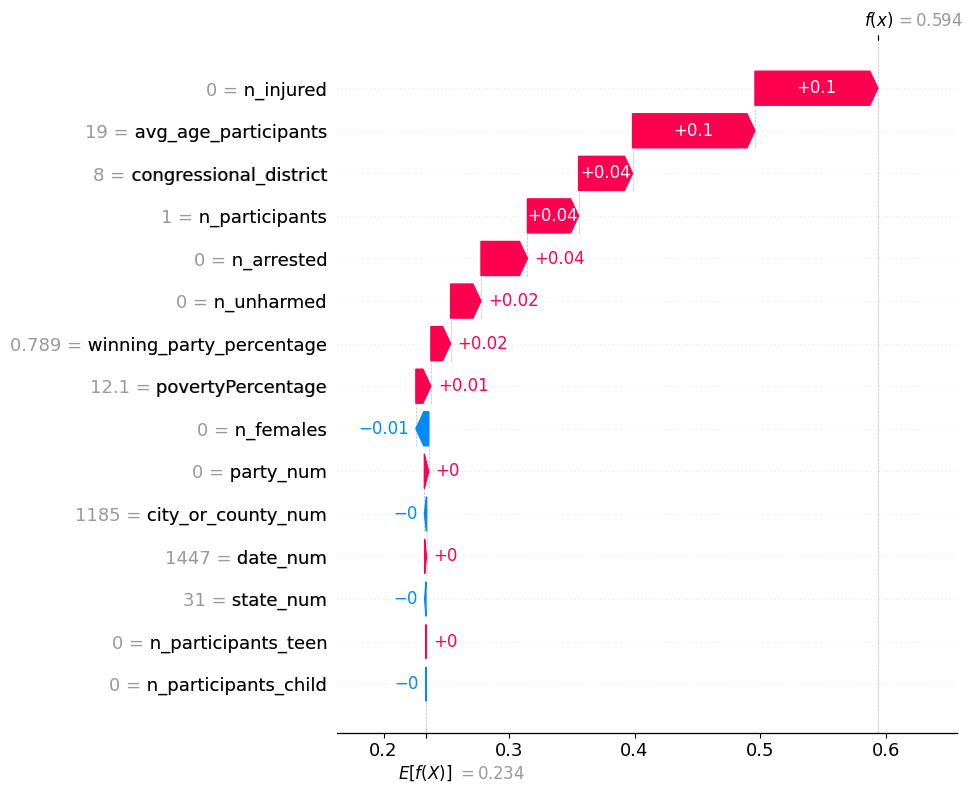

In [101]:
print(y_trvl.iloc[31])
# visualize the first prediction's explanation
id_to_explain = 31
output_to_explain = 1
shap.plots.waterfall(shap_values[id_to_explain,:,output_to_explain],max_display=15)


n_participants_child,n_participants_teen,date_num,state_num,city_or_county_num,party_num

In [102]:
dt[dt["povertyPercentage"] > 20]["state"]
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

# Lime explain

In [103]:
from lime.lime_tabular import LimeTabularExplainer

# Assuming X_train is your training data
explainer = LimeTabularExplainer(np.array(X_trvl), feature_names=X_train.columns, class_names=["No-killing", "Killing"],training_labels=y_trvl,mode="classification",verbose=True)



In [104]:
instance_to_explain = X_test.iloc[0]
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


LABEL: 1
Intercept 0.18495448346511478
Prediction_local [0.57942056]
Right: 0.5938471839671116


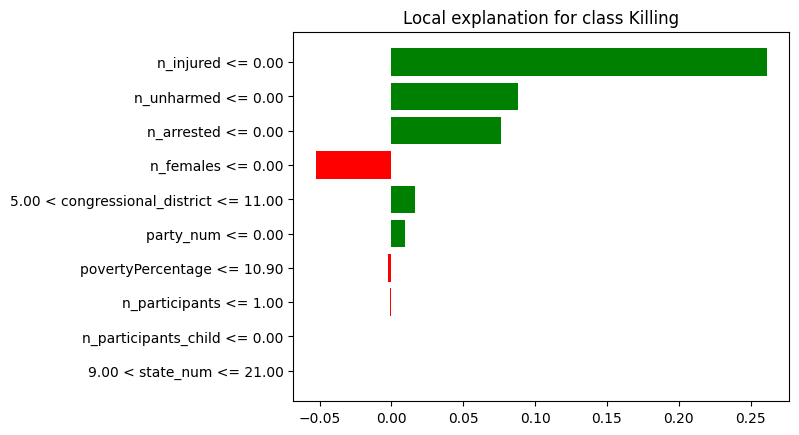

In [105]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [106]:
instance_to_explain = X_test.iloc[100]
print("LABEL:",y_test.iloc[100])

explanation_0 = explainer.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)



LABEL: 0
Intercept 0.4634665868388966
Prediction_local [0.25419989]
Right: 0.29542488739607203


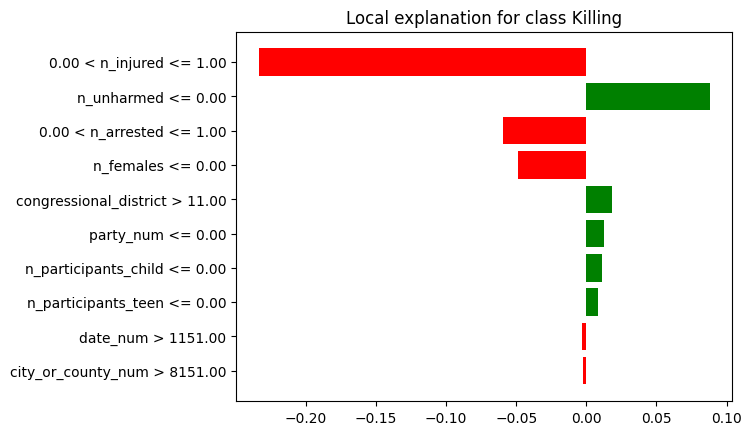

In [107]:
fig = explanation_0.as_pyplot_figure()
plt.show()

## AdaBoost

import libraries for AdaBoost

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier


Grid search AdaBoost

In [ ]:

def getAdaBoostBaseAlgo(num):
    if num == 0:
        return DecisionTreeClassifier(max_depth=5)
    elif num == 1:
        return SVC(probability=True, kernel='rbf')
    elif num == 2:
        return RandomForestClassifier(max_depth=5)
    elif num == 3:
        return LogisticRegression()
                


In [ ]:
def get_ada_boost_grid(X,y):
    params = {
    'base_estimator': [getAdaBoostBaseAlgo(0),getAdaBoostBaseAlgo(1),getAdaBoostBaseAlgo(2),getAdaBoostBaseAlgo(3)],
    'n_estimators': [10,30,100,300], # The maximum number of estimators at which boosting is terminated.
    'learning_rate': [1,0.1],
    'random_state': [None],
    }
    ada_boost_grid = GridSearchCV(AdaBoostClassifier(), params,refit = True, cv=cv_strategy ,scoring='accuracy', n_jobs=10, verbose=10)
    ada_boost_grid.fit(X, y)
    print("Ada Boost - Best parameters set found:")
    print(ada_boost_grid.best_params_)
    print("Ada Boost - Best accuraccy score found:")
    print(ada_boost_grid.best_score_)
    return ada_boost_grid.best_estimator_

In [ ]:
ada_boost_grid = get_ada_boost_grid(X_sc_trvl,y_trvl)
trvl_pred_ada_boost = ada_boost_grid.predict(X_sc_trvl)
test_pred_ada_boost = ada_boost_grid.predict(X_sc_test)
print_accuracy(y_trvl,trvl_pred_ada_boost,test_pred_ada_boost)
report_scores(y_test,test_pred_ada_boost)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits


ValueError: Invalid parameter 'class_weight' for estimator AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5)). Valid parameters are: ['algorithm', 'base_estimator', 'estimator', 'learning_rate', 'n_estimators', 'random_state'].

Oversampling

In [ ]:
ada_boost_grid_over = get_ada_boost_grid(X_sc_trvl_oversampled,y_trvl_oversampled)
trvl_pred_ada_boost_over = ada_boost_grid_over.predict(X_sc_trvl)
test_pred_ada_boost_over = ada_boost_grid_over.predict(X_sc_test)
print_accuracy(y_trvl,trvl_pred_ada_boost_over,test_pred_ada_boost_over)
report_scores(y_test,test_pred_ada_boost_over)

Undersampling

In [ ]:
ada_boost_grid_under = get_ada_boost_grid(X_sc_trvl_undersample,y_trvl_undersample)
trvl_pred_ada_boost_under = ada_boost_grid_under.predict(X_sc_trvl)
test_pred_ada_boost_under = ada_boost_grid_under.predict(X_sc_test)
print_accuracy(y_trvl,trvl_pred_ada_boost_under,test_pred_ada_boost_under)
report_scores(y_test,test_pred_ada_boost_under)

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_ada_boost.values, s=25, cmap='YlGn')

ValueError: Found input variables with inconsistent numbers of samples: [28131, 130710]

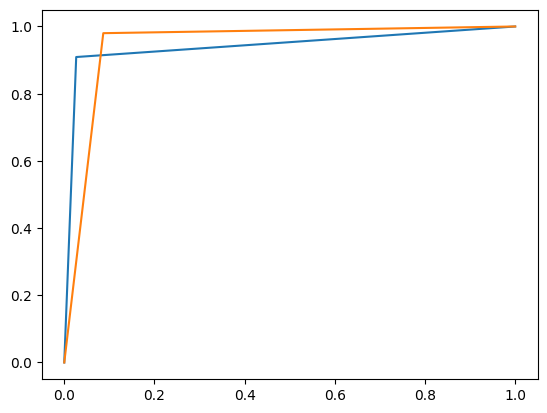

In [ ]:


plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_ada_boost)
auc = metrics.roc_auc_score(y_test, test_pred_ada_boost)
plt.plot(fpr,tpr,label="AdaBoost, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_rf)
auc = metrics.roc_auc_score(y_test, test_pred_rf)
plt.plot(fpr,tpr,label="RandomForest, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_dt)
auc = metrics.roc_auc_score(y_test, test_pred_dt)
plt.plot(fpr,tpr,label="DecisionTree, auc="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test, test_pred_gnb)
auc = metrics.roc_auc_score(y_test, test_pred_gnb)
plt.plot(fpr,tpr,label="Naive Bayes, auc="+str(auc))

plt.legend(loc=0)

## KNN

import libraries for K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


KNN works using a distance function, but distance can not be applied to categorical data. We need to handle categorical values, for example we could drop them.

We define the KNN calssifier by specifying the algorithm and the distance metric to use and we fit it to our data.

In [ ]:

def knn_grid_search(X,y):
    metrics = [
    'euclidean', 
    'minkowski',
    'chebyshev',
    'cosine',
    ]
    params = [{
        'n_neighbors': [10,100,150,200,250,300,600,800,1000],
        'algorithm':['auto','ball_tree'], 
        'metric':metrics, 
        'weights':["distance","uniform"]
        }]
    
        
    knn_grid = GridSearchCV(KNeighborsClassifier(p = 1), params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
    knn_grid.fit(X, y)
    print("K_nn - Best parameters set found:")
    print(knn_grid.best_params_)
    print("K_nn - Best accuraccy score found:")
    print(knn_grid.best_score_)
    return knn_grid.best_estimator_

We run the prediction and evaluate the performance scores for this model.

In [ ]:
knn_grid = knn_grid_search(X_sc_trvl,y_trvl)
test_pred_knn = knn_grid.predict(X_sc_test)
train_pred_knn = knn_grid.predict(X_sc_trvl)
print_accuracy(y_trvl,train_pred_knn,test_pred_knn)
report_scores(y_test,test_pred_knn)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits


KeyboardInterrupt: 

Oversampled

In [ ]:
knn_grid = knn_grid_search(X_sc_trvl_oversampled,y_trvl_oversampled)
train_pred_knn_oversampled = knn_grid.predict(X_sc_trvl_oversampled)
test_pred_knn_oversampled = knn_grid.predict(X_sc_test)
print_accuracy(y_trvl,train_pred_knn_oversampled,test_pred_knn_oversampled)
report_scores(y_test,test_pred_knn_oversampled)

Undersampled

In [ ]:
knn_grid = knn_grid_search(X_sc_trvl_undersample,y_trvl_undersample)
train_pred_knn_undersample = knn_grid.predict(X_sc_trvl_undersample)
test_pred_knn_undersample = knn_grid.predict(X_sc_test)
print_accuracy(y_trvl,train_pred_knn_undersample,test_pred_knn_undersample)
report_scores(y_test,test_pred_knn_undersample)

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_knn.values, s=25, cmap='YlGn')


## SVM

In [ ]:
import scikitplot as skplt


In [ ]:
def get_svm_grid(X,y):
    params = [
        
    {"kernel": ["rbf", "linear", "sigmoid"], "gamma": ["scale", "auto"], "C": [0.1,0.5, 1, 10, 100, 300, 1000],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100},{0:1,1:3}, {0:1,1:5} ]},
    {"kernel": ["poly"], "degree": [2,3,4], "gamma": ["scale", "auto"], "C": [0.1,0.5, 1, 10, 100, 300, 1000],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100},{0:1,1:3}, {0:1,1:5} ]}#C term that gives more freedom for classification errors.

    ] 
    svc_grid = GridSearchCV(SVC(), params, refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=-1, verbose=10)
    svc_grid.fit(X, y)
    print("SVM - Best parameters set found:")
    print(svc_grid.best_params_)
    print("SVM - Best accuracy score found:")
    print(svc_grid.best_score_)
    return svc_grid.best_estimator_

We run the prediction on our test set.

In [ ]:
svc_grid = get_svm_grid(X_sc_trvl,y_trvl)
trvl_pred_proba_svm = svc_grid.predict_proba(X_sc_trvl)
test_pred_proba_svm = svc_grid.predict_proba(X_sc_test)
print_accuracy(y_trvl,trvl_pred_proba_svm,test_pred_proba_svm)
report_scores(y_test,test_pred_proba_svm)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


KeyboardInterrupt: 

Oversampling

In [ ]:
svc_grid_over = get_svm_grid(X_sc_trvl_oversampled,y_trvl_oversampled)
trvl_pred_proba_svm_over = svc_grid_over.predict_proba(X_sc_trvl_oversampled)
test_pred_proba_svm_over = svc_grid_over.predict_proba(X_sc_test)
print_accuracy(y_trvl,trvl_pred_proba_svm_over,test_pred_proba_svm_over)
report_scores(y_test,test_pred_proba_svm_over)

Undersampling

In [ ]:
svc_grid_under = get_svm_grid(X_sc_trvl_undersample,y_trvl_undersample)
trvl_pred_proba_svm_under = svc_grid_under.predict_proba(X_sc_trvl_undersample)
test_pred_proba_svm_under = svc_grid_under.predict_proba(X_sc_test)
print_accuracy(y_trvl,trvl_pred_proba_svm_under,test_pred_proba_svm_under)
report_scores(y_test,test_pred_proba_svm_under)

We plot the ROC curve in order to estimate the goodness of our classification.

In [ ]:
skplt.metrics.plot_roc(y_test.values, test_pred_proba_svm)
plt.show()

ModuleNotFoundError: No module named 'scikitplot'

In [ ]:
plt.scatter(X_sc_test.iloc[:, 3].values, y_test.iloc[:, 6].values, c=test_pred_proba_svm.values, s=25, cmap='YlGn')


## Rule-based classification

In order to run the RIPPER classifier, we run a grip search to find the best configuration parameter values.
In particular, the prune size defines the grow/prune proportion , while k is the number of optimization runs.

In [ ]:
import wittgenstein as lw


In [ ]:
ripper = lw.RIPPER()

def get_rule_grid(X,y):
    params = [{
    "prune_size": [0.5, 0.6], 
    "k": [1, 3, 5],
    "class_weight":['balanced', None, {0: 0.3, 1: 0.7}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100},{0:1,1:3}, {0:1,1:5}]
    }]
    ripper_grid = GridSearchCV(estimator=ripper,param_grid = params,refit = True, cv=cv_strategy, scoring='accuracy', n_jobs=10, verbose=10)
    ripper_grid.fit(X, y)
    print("Ripper - Best parameters set found:")
    print(ripper_grid.best_params_)
    print("Ripper - Best accuraccy score found:")
    print(ripper_grid.best_score_)
    return ripper_grid.best_estimator_

We run the model using the configuration found with grid search.

In [ ]:
rule_grid = get_rule_grid(X_sc_trvl,y_trvl)
datas = pd.concat([X_sc_trvl, y_trvl], axis=1)
rule_grid.fit(datas, class_feat='involve_killing', pos_class=1) 

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

The rules yielded by the RIPPER model are the following.

In [ ]:
rule_grid.out_model()

We predict the class values using the rules found above.

In [ ]:
rule_grid.predict(y_test)

In order to evaluate the goodness of this classfication we compute the performance metrics.

In [ ]:
print('Accuracy ', rule_grid.score(X_sc_test, y_test))
print('Precision ', rule_grid.score(X_sc_test, y_test, precision_score))
print('Recall ', rule_grid.score(X_sc_test, y_test, recall_score))


with rule based classifiers it is possible to extract the reasons for the prediction.
only for the positive predictions

In [ ]:
rule_grid.predict(X_sc_test[:20], give_reasons=True) #Explain the rules behind the first 20 instances that are classified as positive.

oversample

In [ ]:
rule_grid_over = get_rule_grid(X_sc_trvl_oversampled,y_trvl_oversampled)
datas_over = pd.concat([X_sc_trvl_oversampled, y_trvl_oversampled], axis=1)
rule_grid_over.fit(datas_over, class_feat='involve_killing', pos_class=1) 
rule_grid_over.predict(y_test)
print('Accuracy ', rule_grid_over.score(X_sc_test, y_test))
print('Precision ', rule_grid_over.score(X_sc_test, y_test, precision_score))
print('Recall ', rule_grid_over.score(X_sc_test, y_test, recall_score))

Undersample

In [ ]:
rule_grid_under = get_rule_grid(X_sc_trvl_undersample,y_trvl_undersample)
datas_under = pd.concat([X_sc_trvl_undersample, y_trvl_undersample], axis=1)
rule_grid_under.fit(datas_under, class_feat='involve_killing', pos_class=1) 
rule_grid_under.predict(y_test)
print('Accuracy ', rule_grid_under.score(X_sc_test, y_test))
print('Precision ', rule_grid_under.score(X_sc_test, y_test, precision_score))
print('Recall ', rule_grid_under.score(X_sc_test, y_test, recall_score))

## Neural Network

imports of libraries to create NN

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import callbacks
from keras.losses import binary_crossentropy


We start by considering a neural network composed by one layer.

In [ ]:
def createModel(layersConfig,dropout, hiddenActv,outputActv):
  modelLayers = []
  print(layersConfig)
  # Input layer
  input_dim = X_sc_train.shape[1]
  modelLayers.append(Dense(input_dim, activation=hiddenActv, input_dim=input_dim))
  for units in layersConfig:
      modelLayers.append(Dropout(dropout)) # drop dropout_value% of units during learning, in order to reduce overfitting.
      modelLayers.append(Dense(units, activation=hiddenActv, input_dim=input_dim))
      input_dim = units
  # Output layer
  modelLayers.append(Dense(1, activation=outputActv))
  print(modelLayers)
  model = Sequential(modelLayers)
  return model


In [ ]:
'''optimizers = ['sgd','adamax','adam']
loss_functions = ['mean_squared_error', 'binary_crossentropy']
'''
# Define a list of possible lists of number of units for each layer
layersConfig = [([42,12],0.1),([32,12],0.1),([24],0.1),([32],0.1),([12],0.1),([64, 24, 8],0.1)]
                #1) (input + 1) * 2, (input + 1) /2
                #2) (input + 10) + 1, (input - 10) + 1
                #3) random
                #4) random
                #5) (input + 1) /2
                #6) (input + 1) * 3, (input + 3), (input + 1) / 3 

model_information_list = []

for layer_config in layersConfig:
    model = createModel(layer_config[0],layer_config[1],"relu","sigmoid") # relu for hidden, sigmoid for output layer

    # Compile the Neural network model
    model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize
    
    # early loss calculated on validation set, we using the val_loss instead of training_loss because it's a value that better rappresents the efficacy of the model to generalize
    earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",        # quantity to be monitored (validation loss)
    mode="min",                # "min" means training will stop when the quantity monitored has stopped decreasing
    patience=3,                # number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # whether to restore model weights from the epoch with the best value of the monitored quantity
    )
    # model training
    trainedModel = model.fit(X_sc_train, y_train, validation_data = (X_sc_val,y_val),epochs=80, batch_size=512, verbose=0, callbacks=[earlystopping]) #random values for epochs and batch_size

    # evaluate the model on the validation set
    _, accuracy = model.evaluate(X_sc_val, y_val, verbose=0)

    print('NN with ', layer_config, 'configuration - Validation Score:', accuracy,
        '- Epochs:', earlystopping.stopped_epoch)

    model_information_list.append({"earlyStopping":earlystopping,"trainedModel":trainedModel,"accuracyValidation":accuracy,"model":model})



[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B923AC80>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9849990>, <keras.src.layers.core.dense.Dense object at 0x00000266B9B7D7B0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B9B7D240>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6FB010>, <keras.src.layers.core.dense.Dense object at 0x00000266BF6F8B20>]
NN with  ([42, 12], 0.1) configuration - Validation Score: 0.9739308953285217 - Epochs: 20
[32, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266B9B58E20>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF7D15A0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89AE30>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF89ADD0>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B400>, <keras.src.layers.core.dense.Dense object at 0x00000266BF89B520>]


KeyboardInterrupt: 

In [ ]:
index_best_nn = 0 # the best nn on validation set is the first 1
best_history = model_information_list[index_best_nn]["trainedModel"]
best_model = model_information_list[index_best_nn]["model"]

In [ ]:
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 22)                506       
                                                                 
 dropout_51 (Dropout)        (None, 22)                0         
                                                                 
 dense_80 (Dense)            (None, 42)                966       
                                                                 
 dropout_52 (Dropout)        (None, 42)                0         
                                                                 
 dense_81 (Dense)            (None, 12)                516       
                                                                 
 dense_82 (Dense)            (None, 1)                 13        
                                                                 
Total params: 2001 (7.82 KB)
Trainable params: 2001 (

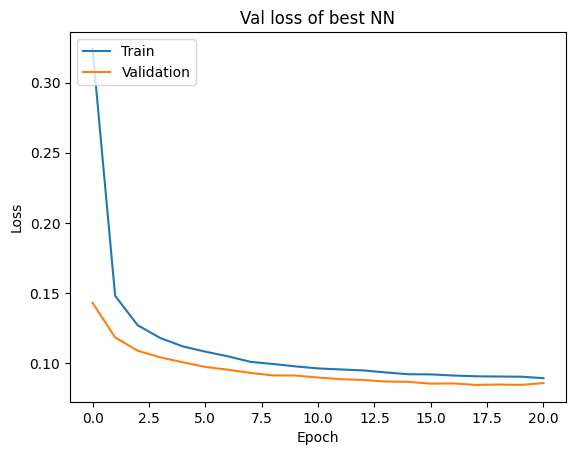

In [ ]:
plt.plot(best_history.history['loss']) 
plt.plot(best_history.history['val_loss']) 
plt.title('Val loss of best NN') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Validation'], loc='upper left') 
plt.show()

Retrain on the development set, by taking the best model and test it on the test set.

In [ ]:
# Builds NN architecture based on the best nn
model = createModel(layersConfig[index_best_nn][0],layersConfig[index_best_nn][1],"relu","sigmoid")
model.compile(optimizer='adam',
                  loss=binary_crossentropy, # suitable for binary classification
                  metrics=['accuracy']) # accuracy on test set to maximize

# Train the model on the development set
final_history = model.fit(X_sc_trvl, y_trvl, validation_data = (X_sc_test, y_test), epochs=20, batch_size=32, verbose=0)

# Evaluate the model on the test set
y_pred_test = np.rint(model.predict(X_sc_test, verbose=0))

[42, 12]
[<keras.src.layers.core.dense.Dense object at 0x00000266BF24CCD0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266BF24EB00>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B67A0>, <keras.src.layers.regularization.dropout.Dropout object at 0x00000266B98B67D0>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B4D30>, <keras.src.layers.core.dense.Dense object at 0x00000266B98B60E0>]


In [ ]:
report_scores(y_test, y_pred_test)

              precision    recall  f1-score   support

 non-killing       0.99      0.98      0.99     21553
     killing       0.94      0.96      0.95      6578

    accuracy                           0.98     28131
   macro avg       0.97      0.97      0.97     28131
weighted avg       0.98      0.98      0.98     28131

